## Builds the CIFAR-10 network.

### Summary of training functions:

 > #### Compute input images and labels for training.
 >>inputs, labels = distorted_inputs()

 >#### Compute inference on the model inputs to make a prediction.
 >>predictions = inference(inputs)

 >#### Compute the total loss of the prediction with respect to the labels.
 >>loss = loss(predictions, labels)

 >#### Create a graph to run one step of training with respect to the loss.
 >>train_op = train(loss, global_step)


In [2]:
import tensorflow as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt

### Set Flags

For Command Line access (But throwing error "Unknown command line flag 'f'"

Hence using a class

In [3]:
# tf.reset_default_graph()


# FLAGS = tf.app.flags.FLAGS

# tf.app.flags.DEFINE_integer('batch_size', 128,
#                             """Number of images to process in a batch.""")
# tf.app.flags.DEFINE_string('data_dir', "/home/sankaran/exercise/ML/TF-Exercise/Tutorials/CIFAR/cifar-10-batches-bin",
#                            """Path to the CIFAR-10 data directory.""")
# tf.app.flags.DEFINE_integer('num_preprocess_threads', 16,
#                             """Number of images to process in a batch.""")

def run_tf(x):
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config) as sess:    
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        out = sess.run(x)

        coord.request_stop()
        coord.join(threads)
        
        return out
    

class FLAGS(object):
    pass

FLAGS.batch_size = 10
FLAGS.data_dir = "/home/sankaran/exercise/ML/TF-Exercise/Tutorials/CIFAR/cifar-10-batches-bin"
FLAGS.num_preprocess_threads = 16

### Getting a batch of distorted inputs

**Note :**
> First batch takes about a minute

In [44]:
def distorted_inputs(data_dir, batch_size, distort=True):
    
    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i) for i in range(1, 6)]
    
    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames,seed=0)
    
    #Create FixedLenthRecord Reader with fixed bytes to read
    record_bytes = 32*32*3+1 #32*32*3 image with 1 byte for label
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    
    key, value = reader.read(filename_queue)
    
    ##Decode
    decoded = tf.decode_raw(value, tf.uint8)
    label = tf.strided_slice(decoded,[0],[1])
    image = tf.strided_slice(decoded,[1],[record_bytes])
    
    
    label = tf.cast(label,tf.int32)
    label = tf.reshape(label,[1])
    image = tf.reshape(image,[3,32,32])
    image = tf.transpose(image,[1,2,0])
    #image = tf.cast(image,tf.float32) ## DESTROYES IMAGE VIS
    
    ##PRE PROCESS
    if(distort):
        image = tf.random_crop(image, [24, 24, 3])
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image,max_delta=0.4)
        image = tf.image.random_contrast(image,lower=0.5,upper=1.8)
    
    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                             min_fraction_of_examples_in_queue)
    
    images, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        num_threads=FLAGS.num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size,
        min_after_dequeue=min_queue_examples,
        seed=0)
    
    return [images,label_batch]


#### CHECK - distorted_inputs( ... ):

Creating session

In [45]:
images, label_batch = distorted_inputs(FLAGS.data_dir, FLAGS.batch_size) #queue runners should be created after this.
#Had to debug that for over an hour

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.InteractiveSession(config=config)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)



First batch

(10, 24, 24, 3) (10, 1)


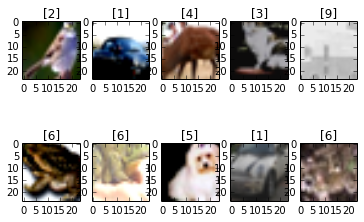

In [46]:
im, l = sess.run([images,label_batch])
print(im.shape,l.shape)
for j in range(len(im)):
    plt.subplot(2, 5, j+1)
    plt.imshow(im[j, ...])
    plt.title(str(l[j]))
plt.show()

Second batch

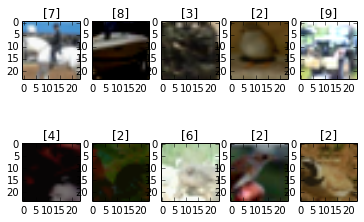

In [47]:
im, l = sess.run([images,label_batch])
for j in range(len(im)):
    plt.subplot(2, 5, j+1)
    plt.imshow(im[j, ...])
    plt.title(str(l[j]))
plt.show()